In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm, notebook,trange
from sklearn.linear_model import LogisticRegression
from keras.preprocessing import image
from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import recall_score as rec_score
from sklearn.metrics import precision_score as prec_score
from sklearn.metrics import f1_score as f_scores
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

In [2]:
    from keras import backend as K
from keras.applications import resnet,vgg19,vgg16,xception,inception_v3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten,BatchNormalization
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
import plotly as px
import plotly.graph_objects as go

In [3]:
ResNet50,VGG19,VGG16,Xception,InceptionV3 = resnet.ResNet50,vgg19.VGG19,vgg16.VGG16,xception.Xception,inception_v3.InceptionV3

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.style.use('fivethirtyeight')

import warnings 
warnings.filterwarnings(action="ignore")

In [5]:
train = pd.read_csv("meta_region.csv")

In [6]:
train.head()

,W_fname,age,filename,sex,country,path,length,length_clean,Continent
0,afrikaans1.wav,27.0,afrikaans1,female,south africa,/content/drive/MyDrive/SpeechAccentData/afrika...,20.772268,20.772313,Africa
1,afrikaans2.wav,40.0,afrikaans2,male,south africa,/content/drive/MyDrive/SpeechAccentData/afrika...,21.961497,21.496500,Africa
2,afrikaans3.wav,43.0,afrikaans3,male,south africa,/content/drive/MyDrive/SpeechAccentData/afrika...,26.880000,26.880000,Africa
3,afrikaans4.wav,26.0,afrikaans4,male,south africa,/content/drive/MyDrive/SpeechAccentData/afrika...,23.471179,23.020375,Africa
4,afrikaans5.wav,19.0,afrikaans5,male,south africa,/content/drive/MyDrive/SpeechAccentData/afrika...,20.252404,20.252437,Africa


In [7]:
conditions = [
    (train['age'] >=0 ) & (train['age'] <= 25),
    (train['age'] >=26 ) & (train['age'] <= 50),
    (train['age'] >50 )]
choices = ['Teen', 'Adult', 'OldAge']
train['age'] = np.select(conditions, choices, default='NA')

In [8]:
train.head()

,W_fname,age,filename,sex,country,path,length,length_clean,Continent
0,afrikaans1.wav,Adult,afrikaans1,female,south africa,/content/drive/MyDrive/SpeechAccentData/afrika...,20.772268,20.772313,Africa
1,afrikaans2.wav,Adult,afrikaans2,male,south africa,/content/drive/MyDrive/SpeechAccentData/afrika...,21.961497,21.496500,Africa
2,afrikaans3.wav,Adult,afrikaans3,male,south africa,/content/drive/MyDrive/SpeechAccentData/afrika...,26.880000,26.880000,Africa
3,afrikaans4.wav,Adult,afrikaans4,male,south africa,/content/drive/MyDrive/SpeechAccentData/afrika...,23.471179,23.020375,Africa
4,afrikaans5.wav,Teen,afrikaans5,male,south africa,/content/drive/MyDrive/SpeechAccentData/afrika...,20.252404,20.252437,Africa


# Visualisation

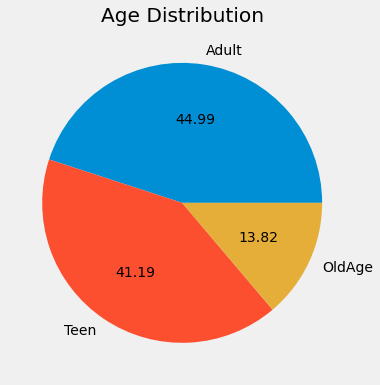

In [21]:
plt.title("Age Distribution")
plt.pie(train.age.value_counts().values,labels=train.age.value_counts().index,autopct="%0.2f")
plt.show()

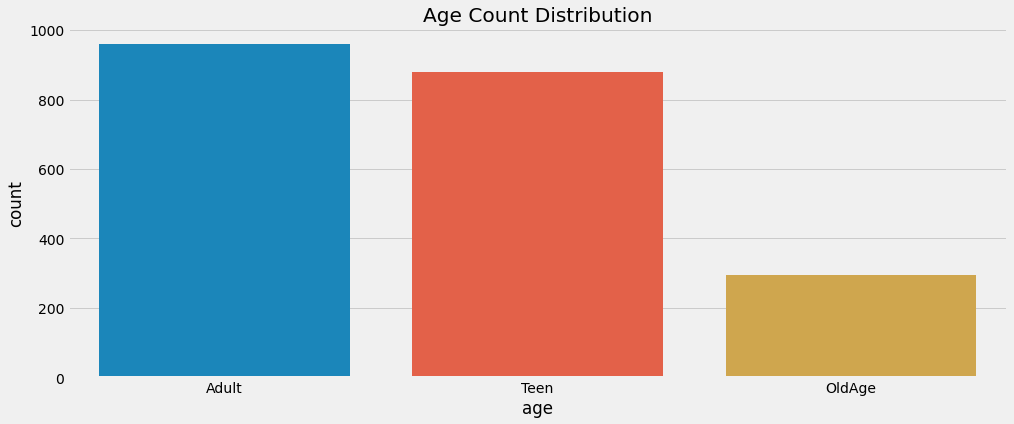

In [22]:
plt.title("Age Count Distribution")
sns.countplot(x=train.age)
plt.show()

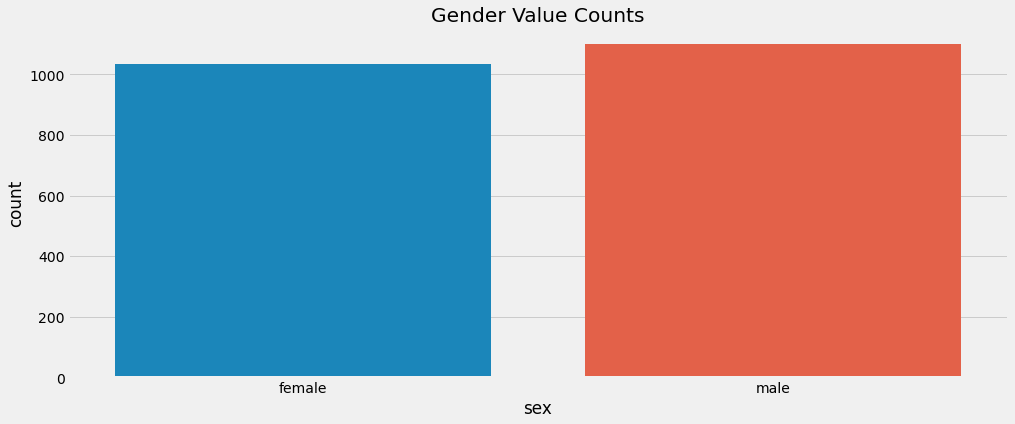

In [ ]:
plt.title("Gender Value Counts")
sns.countplot(x=train.sex)
plt.show()

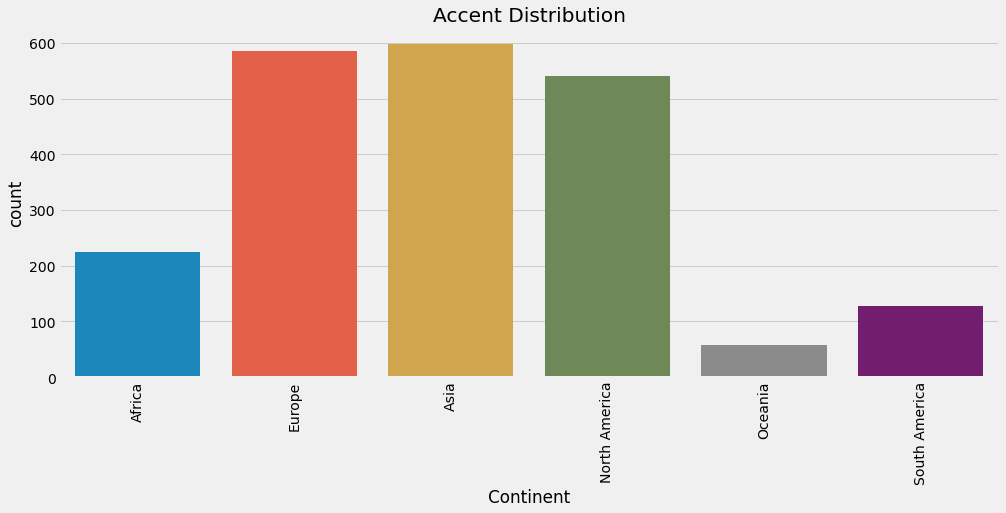

In [ ]:
plt.title("Accent Distribution")
sns.countplot(x=train.Continent)
plt.xticks(rotation=90)
plt.show()

# Visualizing some features of Audio wave

In [23]:
voice_dir = "..." # path of voice data
sample_rate = 16000

In [26]:
# Taking Random voice sample
idx = np.random.randint(0,len(train))
# storing idx'th voice fiel name
filename = voice_dir +"/"+train.filename[idx]


### Audio Wave

<Figure size 864x216 with 0 Axes>

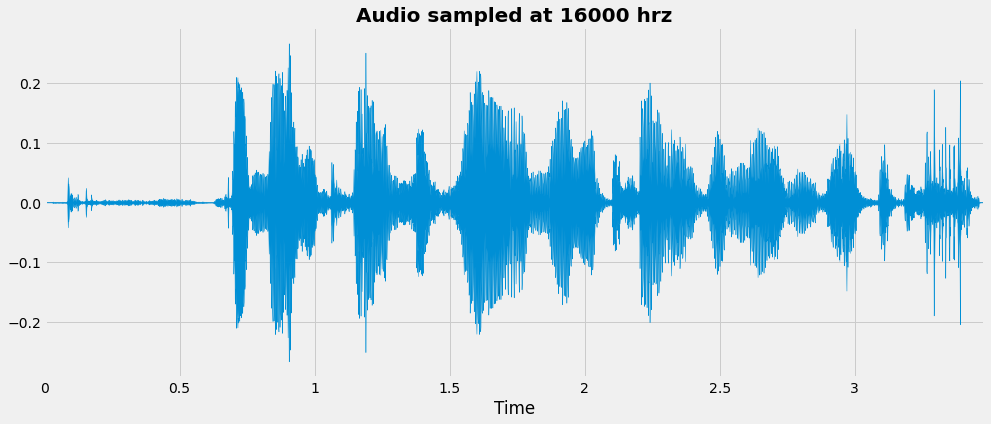

In [ ]:
# Loading audio sample
audio_array, sampling_rate = librosa.load(filename, sr=sample_rate)
# Creating figure
plt.figure(figsize=(12, 3))
plt.figure()
librosa.display.waveplot(audio_array, sr=sampling_rate)
plt.title('Audio sampled at {} hrz'.format(sample_rate),fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.show()

### Mel-Frequency Cepstral Coefficient

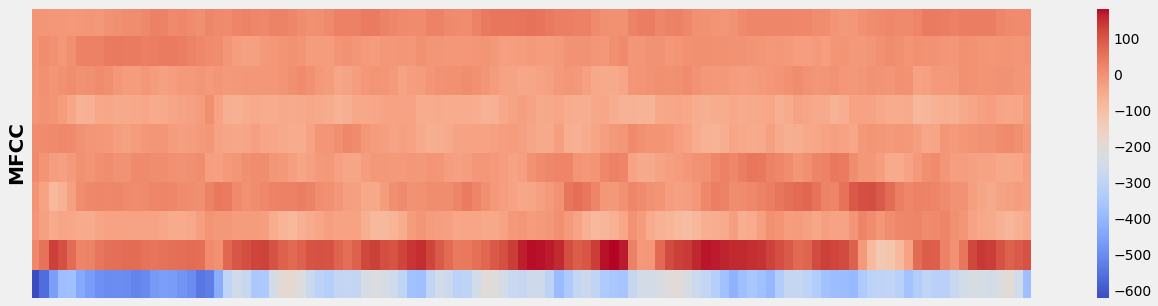

In [ ]:
# Loading Audio sample
audio_array,sampling_rate = librosa.load(filename, sr=sample_rate) 
# MFCC with 10 components
mfcc = librosa.feature.mfcc(y=audio_array, sr=sample_rate, n_mfcc = 10) 

plt.figure(figsize=(20,5))
librosa.display.specshow(mfcc)
plt.ylabel('MFCC',fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.colorbar()
plt.show()

###  Log Mel-spectogram

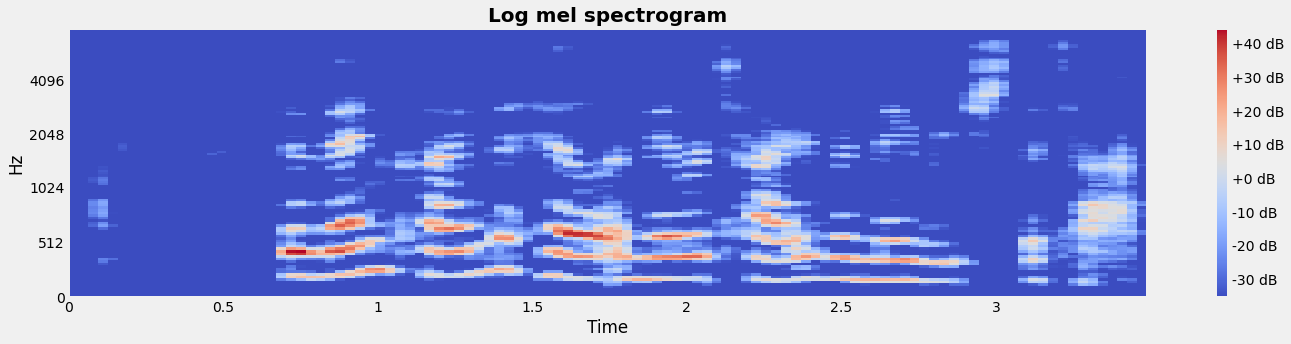

In [ ]:
audio_array, sampling_rate = librosa.load(filename, sr=sample_rate) 
mel_spectogram = librosa.feature.melspectrogram(audio_array, sr=sampling_rate, n_mels=128)

# Convert to log scale
log_S = librosa.amplitude_to_db(mel_spectogram)

# Plotting Log Mel-Spectogram
plt.figure(figsize=(20,5))
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram',fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

### Chroma

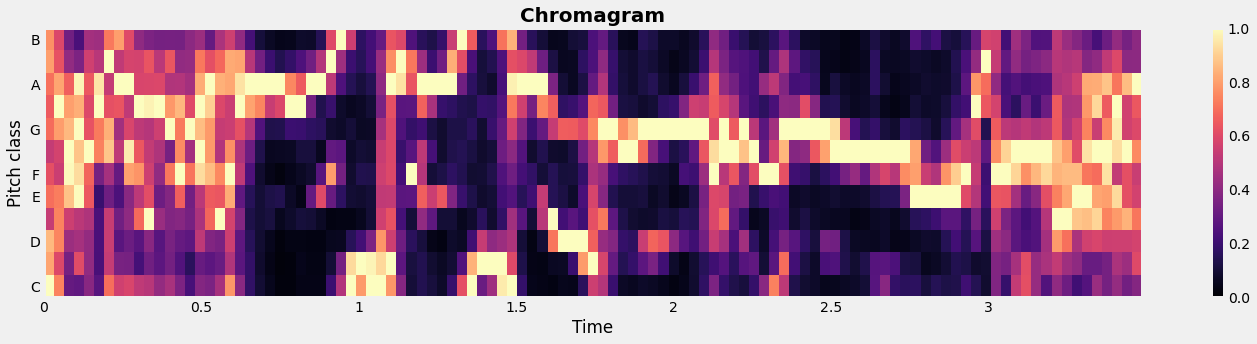

In [ ]:
audio_array, sampling_rate = librosa.load(filename, sr=sample_rate)
chroma = librosa.feature.chroma_cqt(y=audio_array, sr=sampling_rate)


plt.figure(figsize=(20,5))

librosa.display.specshow(chroma, sr=sampling_rate, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title('Chromagram',fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.colorbar()
plt.tight_layout()

# Audio Preprocessing

In [ ]:
scaler = MinMaxScaler()

In [ ]:
def process_data(file,target_dir):  
    filename = voice_dir +  "/" + file
    y, s = librosa.load(filename, sr=16000)
    y_filt = librosa.effects.preemphasis(y)
    S_preemph = librosa.amplitude_to_db(np.abs(librosa.stft(y_filt)), ref=np.max)
    S_preemph = scaler.fit_transform(S_preemph)
    #librosa.display.specshow(S_preemph, y_axis='log', x_axis='time')
    plt.imshow(S_preemph.T,cmap='plasma')
    plt.axis("off")
    file = file.split("/")[1]
    address = target_dir+"/"+"{}.png".format(file)
    plt.savefig(address)
    plt.close()

In [9]:
train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('/content/drive/MyDrive/clean_random_images_10sec_cropped/'+train['filename'][i]+'.png',target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 2134/2134 [00:08<00:00, 250.70it/s]


# Defining models

In [20]:
depth = 3
INIT_LR = 0.001
EPOCHS = 10
inputShape = (224,224,3)

In [11]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def spec_sens(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    sensitivity = TP/(TP+FN)
    # Specificity or true negative rate
    specificity = TN/(TN+FP) 
    
    return sensitivity,specificity

### Dense Architechture

In [66]:
def dense_model(base_model,num_classes):
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [13]:
def define_models(classes):
    num_class = classes
    #Xception
    model_xcep = Xception(include_top=False, weights="imagenet",input_shape =inputShape)
    model_xception = dense_model(model_xcep,num_class)
    model_xception.layers[0].trainable = False

    # InceptionV3
    model_incep = InceptionV3(include_top=False, weights="imagenet",input_shape =inputShape)
    model_inception = dense_model(model_incep,num_class)
    model_inception.layers[0].trainable = False

    #VGG16
    model_1 = VGG16(include_top=False, weights="imagenet",input_shape =inputShape)
    model_vgg1 = dense_model(model_1,num_class)
    model_vgg1.layers[0].trainable = False

    #VGG 19
    model_2 = VGG19(include_top=False, weights="imagenet",input_shape =inputShape)
    model_vgg2 = dense_model(model_2,num_class)
    model_vgg2.layers[0].trainable = False

    #ResNet50
    model_res = ResNet50(include_top=False, weights="imagenet",input_shape =inputShape)
    model_resnet = dense_model(model_res,num_class)
    model_resnet.layers[0].trainable = False

    return [model_xception,model_inception,model_vgg1,model_vgg2,model_resnet]

### Ensemble

In [14]:
def stacking_predictions(models,data):
    # array to store values
    stackValues = None
    for model in models:
        # making predictions for each model
        y_pred = model.predict(data)
        # stack predictions into [rows, members, probabilities]
        if stackValues is None:
            stackValues = y_pred
        else:
            stackValues = np.dstack((stackValues,y_pred))
    # flatten predictions to [rows, members x probabilities]
    stackValues = stackValues.reshape((stackValues.shape[0], stackValues.shape[1]*stackValues.shape[2]))
    return stackValues

In [44]:
def fit_models(models,data,labels):
    # stacked data with ensemble
    stackedValues = stacking_predictions(models,data)
    log_reg = LogisticRegression()
    labels = np.argmax((labels.values),axis=1)
    log_reg.fit(stackedValues,labels)
    return log_reg

In [16]:
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacking_predictions(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

# Gender prediction

In [17]:
label = pd.get_dummies(train['sex'])
X_train, X_test, y_train, y_test = train_test_split(X, label, random_state=42, test_size=0.2)

In [23]:
model_xception,model_inception,model_vgg1,model_vgg2,model_resnet = define_models(2)

### Exception Model

In [24]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_xception.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_exception = model_xception.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/10
54/54 [==============================] - 44s 238ms/step - loss: 0.9013 - accuracy: 0.5652 - recall_score: 0.5653 - precision_score: 0.5653 - f1_score: 0.5653 - val_loss: 0.5412 - val_accuracy: 0.7728 - val_recall_score: 0.7750 - val_precision_score: 0.7750 - val_f1_score: 0.7750
Epoch 2/10
54/54 [==============================] - 9s 160ms/step - loss: 0.6606 - accuracy: 0.6347 - recall_score: 0.6347 - precision_score: 0.6347 - f1_score: 0.6347 - val_loss: 0.4917 - val_accuracy: 0.7564 - val_recall_score: 0.7593 - val_precision_score: 0.7593 - val_f1_score: 0.7593
Epoch 3/10
54/54 [==============================] - 9s 162ms/step - loss: 0.5508 - accuracy: 0.7311 - recall_score: 0.7312 - precision_score: 0.7312 - f1_score: 0.7312 - val_loss: 0.4208 - val_accuracy: 0.8126 - val_recall_score: 0.8129 - val_precision_score: 0.8129 - val_f1_score: 0.8129
Epoch 4/10
54/54 [==============================] - 9s 164ms/step - loss: 0.4693 - accuracy: 0.7969 - 

In [25]:
pred = np.argmax(model_xception.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)
sensitivity,specificity = spec_sens(conf_matrix)
print('xception Test Sensitivity per class: ' ,sensitivity)
print('xception Test Specificity per class: ' , specificity)

xception Test Sensitivity per class:  [0.84615385 0.96601942]
xception Test Specificity per class:  [0.96601942 0.84615385]


### Inception V3

In [26]:

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_inception.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_inception = model_inception.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/10
54/54 [==============================] - 32s 250ms/step - loss: 0.9288 - accuracy: 0.5321 - recall_score: 0.5321 - precision_score: 0.5321 - f1_score: 0.5321 - val_loss: 0.4511 - val_accuracy: 0.8009 - val_recall_score: 0.8060 - val_precision_score: 0.8060 - val_f1_score: 0.8060
Epoch 2/10
54/54 [==============================] - 5s 98ms/step - loss: 0.6390 - accuracy: 0.6651 - recall_score: 0.6651 - precision_score: 0.6651 - f1_score: 0.6651 - val_loss: 0.4255 - val_accuracy: 0.7963 - val_recall_score: 0.8015 - val_precision_score: 0.8015 - val_f1_score: 0.8015
Epoch 3/10
54/54 [==============================] - 6s 104ms/step - loss: 0.4882 - accuracy: 0.7792 - recall_score: 0.7792 - precision_score: 0.7792 - f1_score: 0.7792 - val_loss: 0.3898 - val_accuracy: 0.8267 - val_recall_score: 0.8306 - val_precision_score: 0.8306 - val_f1_score: 0.8306
Epoch 4/10
54/54 [==============================] - 5s 100ms/step - loss: 0.4681 - accuracy: 0.7966 - r

In [27]:
pred = np.argmax(model_inception.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)
sensitivity,specificity = spec_sens(conf_matrix)
print('Inception Test Sensitivity per class: ' ,sensitivity)
print('Inception Test Specificity per class: ' , specificity)

Inception Test Sensitivity per class:  [0.92391304 0.90123457]
Inception Test Specificity per class:  [0.90123457 0.92391304]


### VGG16

In [28]:

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_vgg1.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_vgg1 = model_vgg1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/10
54/54 [==============================] - 22s 227ms/step - loss: 0.9104 - accuracy: 0.5560 - recall_score: 0.5560 - precision_score: 0.5560 - f1_score: 0.5560 - val_loss: 0.5332 - val_accuracy: 0.8454 - val_recall_score: 0.8484 - val_precision_score: 0.8484 - val_f1_score: 0.8484
Epoch 2/10
54/54 [==============================] - 9s 163ms/step - loss: 0.6715 - accuracy: 0.6756 - recall_score: 0.6757 - precision_score: 0.6757 - f1_score: 0.6757 - val_loss: 0.4852 - val_accuracy: 0.8197 - val_recall_score: 0.8239 - val_precision_score: 0.8239 - val_f1_score: 0.8239
Epoch 3/10
54/54 [==============================] - 9s 165ms/step - loss: 0.5416 - accuracy: 0.7593 - recall_score: 0.7593 - precision_score: 0.7593 - f1_score: 0.7593 - val_loss: 0.4123 - val_accuracy: 0.8595 - val_recall_score: 0.8618 - val_precision_score: 0.8618 - val_f1_score: 0.8618
Epoch 4/10
54/54 [==============================] - 9s 163ms/step - loss: 0.4262 - accuracy: 0.8038 - 

In [30]:
pred = np.argmax(model_vgg1.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)
sensitivity,specificity = spec_sens(conf_matrix)
print('VGG16 Test Sensitivity per class: ' ,sensitivity)
print('VGG16 Test Specificity per class: ' , specificity)

VGG16 Test Sensitivity per class:  [0.93193717 0.93220339]
VGG16 Test Specificity per class:  [0.93220339 0.93193717]


### VGG19

In [31]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_vgg2.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_vgg2 = model_vgg2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/10
54/54 [==============================] - 15s 211ms/step - loss: 0.8664 - accuracy: 0.5361 - recall_score: 0.5360 - precision_score: 0.5360 - f1_score: 0.5360 - val_loss: 0.5597 - val_accuracy: 0.7822 - val_recall_score: 0.7796 - val_precision_score: 0.7796 - val_f1_score: 0.7796
Epoch 2/10
54/54 [==============================] - 11s 198ms/step - loss: 0.7216 - accuracy: 0.6031 - recall_score: 0.6031 - precision_score: 0.6031 - f1_score: 0.6031 - val_loss: 0.4713 - val_accuracy: 0.8431 - val_recall_score: 0.8462 - val_precision_score: 0.8462 - val_f1_score: 0.8462
Epoch 3/10
54/54 [==============================] - 11s 202ms/step - loss: 0.5168 - accuracy: 0.7366 - recall_score: 0.7366 - precision_score: 0.7366 - f1_score: 0.7366 - val_loss: 0.3714 - val_accuracy: 0.9110 - val_recall_score: 0.9152 - val_precision_score: 0.9152 - val_f1_score: 0.9152
Epoch 4/10
54/54 [==============================] - 11s 200ms/step - loss: 0.4857 - accuracy: 0.7736

In [32]:
pred = np.argmax(model_vgg2.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)

sensitivity,specificity = spec_sens(conf_matrix)
print('VGG19 Test Sensitivity per class: ' ,sensitivity)
print('VGG19 Test Specificity per class: ' , specificity)

VGG19 Test Sensitivity per class:  [0.92783505 0.93991416]
VGG19 Test Specificity per class:  [0.93991416 0.92783505]


### Resnet

In [33]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_resnet.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_resnet = model_resnet.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/10
54/54 [==============================] - 24s 227ms/step - loss: 1.0126 - accuracy: 0.5634 - recall_score: 0.5635 - precision_score: 0.5635 - f1_score: 0.5635 - val_loss: 0.8648 - val_accuracy: 0.5457 - val_recall_score: 0.5457 - val_precision_score: 0.5457 - val_f1_score: 0.5457
Epoch 2/10
54/54 [==============================] - 7s 128ms/step - loss: 0.7630 - accuracy: 0.6307 - recall_score: 0.6306 - precision_score: 0.6306 - f1_score: 0.6306 - val_loss: 0.6931 - val_accuracy: 0.5457 - val_recall_score: 0.5457 - val_precision_score: 0.5457 - val_f1_score: 0.5457
Epoch 3/10
54/54 [==============================] - 7s 129ms/step - loss: 0.6220 - accuracy: 0.7088 - recall_score: 0.7089 - precision_score: 0.7089 - f1_score: 0.7089 - val_loss: 0.7514 - val_accuracy: 0.5480 - val_recall_score: 0.5479 - val_precision_score: 0.5479 - val_f1_score: 0.5479
Epoch 4/10
54/54 [==============================] - 7s 131ms/step - loss: 0.5560 - accuracy: 0.7526 - 

In [34]:
pred = np.argmax(model_resnet.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)
sensitivity,specificity = spec_sens(conf_matrix)
print('Resnet Test Sensitivity per class: ' ,sensitivity)
print('Resnet Test Specificity per class: ' , specificity)

Resnet Test Sensitivity per class:  [0.92893401 0.95217391]
Resnet Test Specificity per class:  [0.95217391 0.92893401]


### Stacking Classifiers

In [46]:
stack_models = [model_xception,model_inception,model_vgg1,model_vgg2,model_resnet]
model = fit_models(stack_models,X_train,y_train)
stack_prediction_labels = stacked_prediction(stack_models, model, X_test)
y_label=  np.argmax((y_test.values),axis=1)
acc = acc_score(y_label, stack_prediction_labels)
recall = rec_score(y_label, stack_prediction_labels,average="weighted")
precision = prec_score(y_label, stack_prediction_labels,average="weighted")
fscore = f_scores(y_label, stack_prediction_labels,average="weighted")
conf_matrix = confusion_matrix(y_label, stack_prediction_labels)
print('Stacked Test Accuracy: %.3f' % acc)
print('Stacked Test Recall: %.3f' % recall)
print('Stacked Test Precision: %.3f' % precision)
print('Stacked Test F1Score : %.3f' % fscore)
print('Stacked Test F1Score : %.3f' % fscore)
sensitivity,specificity = spec_sens(conf_matrix)
print('Stacked Test Sensitivity per class: ' % sensitivity)
print('Stacked Test Specificity per class: ' % specificity)

Stacked Test Accuracy: 0.951
Stacked Test Recall: 0.951
Stacked Test Precision: 0.951
Stacked Test F1Score : 0.951
Stacked Test F1Score : 0.951
Stacked Test Sensitivity per class: 
Stacked Test Specificity per class: 


### Plotting Graphs

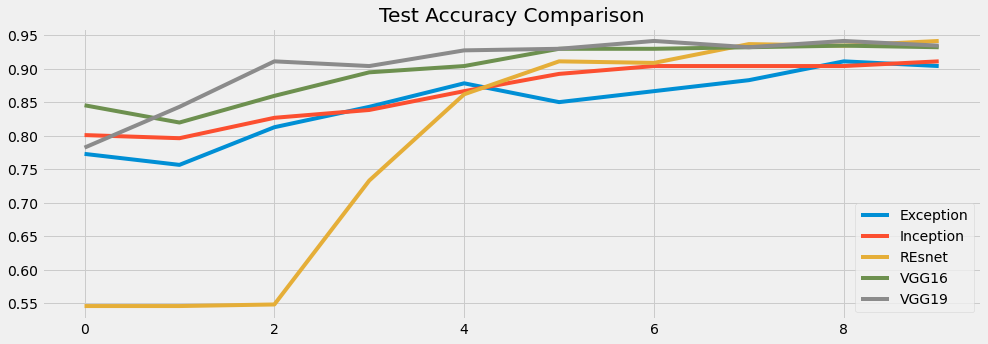

In [47]:
plt.figure(figsize=(15,5))
plt.title("Test Accuracy Comparison")
plt.plot(history_exception.history["val_accuracy"],label = "Exception")
plt.plot(history_inception.history["val_accuracy"],label = "Inception")
plt.plot(history_resnet.history["val_accuracy"],label = "REsnet")
plt.plot(history_vgg1.history["val_accuracy"],label = "VGG16")
plt.plot(history_vgg2.history["val_accuracy"],label = "VGG19")
plt.legend()
plt.show()

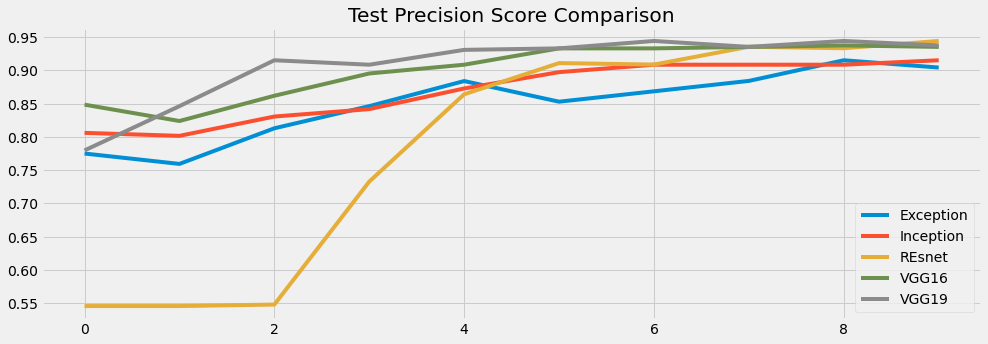

In [48]:
plt.figure(figsize=(15,5))
plt.title("Test Precision Score Comparison")
plt.plot(history_exception.history["val_precision_score"],label = "Exception")
plt.plot(history_inception.history["val_precision_score"],label = "Inception")
plt.plot(history_resnet.history["val_precision_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_precision_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_precision_score"],label = "VGG19")
plt.legend()
plt.show()

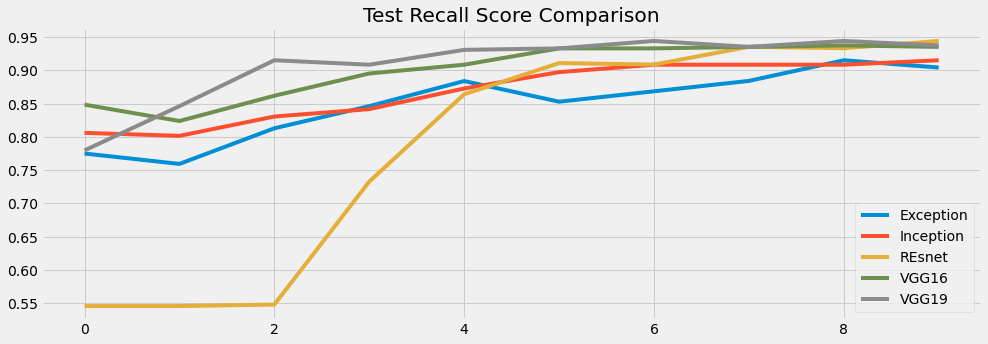

In [49]:
plt.figure(figsize=(15,5))
plt.title("Test Recall Score Comparison")
plt.plot(history_exception.history["val_recall_score"],label = "Exception")
plt.plot(history_inception.history["val_recall_score"],label = "Inception")
plt.plot(history_resnet.history["val_recall_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_recall_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_recall_score"],label = "VGG19")
plt.legend()
plt.show()

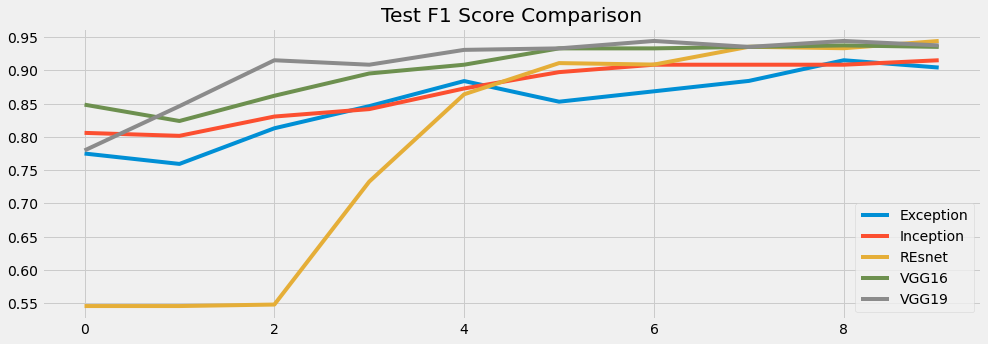

In [50]:
plt.figure(figsize=(15,5))
plt.title("Test F1 Score Comparison")
plt.plot(history_exception.history["val_f1_score"],label = "Exception")
plt.plot(history_inception.history["val_f1_score"],label = "Inception")
plt.plot(history_resnet.history["val_f1_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_f1_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_f1_score"],label = "VGG19")
plt.legend()
plt.show()

# AGE Group Prediction

In [59]:
label = pd.get_dummies(train['age'])
X_train, X_test, y_train, y_test = train_test_split(X, label, random_state=42, test_size=0.2)

In [68]:
model_xception,model_inception,model_vgg1,model_vgg2,model_resnet = define_models(y_train.shape[1])

### Xception

In [69]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_xception.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_xception = model_xception.fit(X_train, y_train.values, epochs=10, validation_data=(X_test, y_test.values))

[INFO] training network...
Epoch 1/10
54/54 [==============================] - 22s 238ms/step - loss: 1.5755 - accuracy: 0.3525 - recall_score: 0.2767 - precision_score: 0.3510 - f1_score: 0.3090 - val_loss: 1.0488 - val_accuracy: 0.4192 - val_recall_score: 0.0179 - val_precision_score: 0.2500 - val_f1_score: 0.0330
Epoch 2/10
54/54 [==============================] - 10s 187ms/step - loss: 1.4316 - accuracy: 0.3479 - recall_score: 0.2741 - precision_score: 0.3527 - f1_score: 0.3079 - val_loss: 1.0127 - val_accuracy: 0.4239 - val_recall_score: 0.0467 - val_precision_score: 0.3387 - val_f1_score: 0.0808
Epoch 3/10
54/54 [==============================] - 10s 189ms/step - loss: 1.3124 - accuracy: 0.3938 - recall_score: 0.3118 - precision_score: 0.4065 - f1_score: 0.3520 - val_loss: 1.0163 - val_accuracy: 0.4309 - val_recall_score: 0.0623 - val_precision_score: 0.4321 - val_f1_score: 0.1048
Epoch 4/10
54/54 [==============================] - 9s 175ms/step - loss: 1.2234 - accuracy: 0.4153 

In [70]:
pred = np.argmax(model_xception.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)
sensitivity,specificity = spec_sens(conf_matrix)
print('xception Test Sensitivity per class: ' ,sensitivity)
print('xception Test Specificity per class: ' , specificity)

xception Test Sensitivity per class:  [0.45510836        nan 0.43269231]
xception Test Specificity per class:  [0.55769231 0.85245902 0.60990712]


### Inception V3

In [71]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_inception.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_inception= model_inception.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/10
54/54 [==============================] - 29s 235ms/step - loss: 1.6140 - accuracy: 0.3327 - recall_score: 0.2600 - precision_score: 0.3260 - f1_score: 0.2889 - val_loss: 1.1008 - val_accuracy: 0.3958 - val_recall_score: 0.0377 - val_precision_score: 0.4274 - val_f1_score: 0.0684
Epoch 2/10
54/54 [==============================] - 5s 97ms/step - loss: 1.2965 - accuracy: 0.4085 - recall_score: 0.3115 - precision_score: 0.4249 - f1_score: 0.3587 - val_loss: 1.0118 - val_accuracy: 0.4473 - val_recall_score: 0.1425 - val_precision_score: 0.4631 - val_f1_score: 0.2163
Epoch 3/10
54/54 [==============================] - 6s 103ms/step - loss: 1.2232 - accuracy: 0.3928 - recall_score: 0.2938 - precision_score: 0.4056 - f1_score: 0.3398 - val_loss: 1.0055 - val_accuracy: 0.4520 - val_recall_score: 0.2206 - val_precision_score: 0.4598 - val_f1_score: 0.2970
Epoch 4/10
54/54 [==============================] - 6s 104ms/step - loss: 1.1670 - accuracy: 0.4002 - r

In [72]:
pred = np.argmax(model_inception.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)
print('Inception Test Sensitivity per class: ' ,sensitivity)
print('Inception Test Specificity per class: ' , specificity)

Inception Test Sensitivity per class:  [0.45510836        nan 0.43269231]
Inception Test Specificity per class:  [0.55769231 0.85245902 0.60990712]


### VGG 16

In [73]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_vgg1.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_vgg1= model_vgg1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/10
54/54 [==============================] - 13s 175ms/step - loss: 1.5216 - accuracy: 0.3609 - recall_score: 0.2862 - precision_score: 0.3722 - f1_score: 0.3229 - val_loss: 1.0350 - val_accuracy: 0.4309 - val_recall_score: 0.1983 - val_precision_score: 0.5080 - val_f1_score: 0.2823
Epoch 2/10
54/54 [==============================] - 8s 158ms/step - loss: 1.4035 - accuracy: 0.3756 - recall_score: 0.2889 - precision_score: 0.3908 - f1_score: 0.3317 - val_loss: 1.0064 - val_accuracy: 0.4824 - val_recall_score: 0.1291 - val_precision_score: 0.4649 - val_f1_score: 0.2001
Epoch 3/10
54/54 [==============================] - 9s 161ms/step - loss: 1.2477 - accuracy: 0.4078 - recall_score: 0.2986 - precision_score: 0.4280 - f1_score: 0.3511 - val_loss: 0.9967 - val_accuracy: 0.5129 - val_recall_score: 0.1045 - val_precision_score: 0.4672 - val_f1_score: 0.1694
Epoch 4/10
54/54 [==============================] - 9s 164ms/step - loss: 1.1849 - accuracy: 0.4437 - 

In [74]:
pred = np.argmax(model_vgg1.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)
sensitivity,specificity = spec_sens(conf_matrix)
print('VGG16 Test Sensitivity per class: ' ,sensitivity)
print('VGG16 Test Specificity per class: ' , specificity)

VGG16 Test Sensitivity per class:  [0.53793103        nan 0.5070922 ]
VGG16 Test Specificity per class:  [0.59219858 0.85245902 0.80689655]


### VGG 19

In [75]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_vgg2.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_vgg2= model_vgg2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/10
54/54 [==============================] - 15s 210ms/step - loss: 1.5791 - accuracy: 0.3486 - recall_score: 0.2939 - precision_score: 0.3724 - f1_score: 0.3281 - val_loss: 1.0692 - val_accuracy: 0.4215 - val_recall_score: 0.0089 - val_precision_score: 0.1964 - val_f1_score: 0.0168
Epoch 2/10
54/54 [==============================] - 10s 195ms/step - loss: 1.4102 - accuracy: 0.3931 - recall_score: 0.3013 - precision_score: 0.4025 - f1_score: 0.3437 - val_loss: 1.0610 - val_accuracy: 0.4286 - val_recall_score: 0.0601 - val_precision_score: 0.4619 - val_f1_score: 0.1056
Epoch 3/10
54/54 [==============================] - 11s 200ms/step - loss: 1.2387 - accuracy: 0.4111 - recall_score: 0.3045 - precision_score: 0.4380 - f1_score: 0.3581 - val_loss: 1.0453 - val_accuracy: 0.4356 - val_recall_score: 0.0110 - val_precision_score: 0.2143 - val_f1_score: 0.0206
Epoch 4/10
54/54 [==============================] - 11s 209ms/step - loss: 1.2030 - accuracy: 0.4171

In [76]:
pred = np.argmax(model_vgg2.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)
sensitivity,specificity = spec_sens(conf_matrix)
print('VGG19 Test Sensitivity per class: ' ,sensitivity)
print('VGG19 Test Specificity per class: ' , specificity)

VGG19 Test Sensitivity per class:  [0.51123596        nan 0.4939759 ]
VGG19 Test Specificity per class:  [0.59036145 0.85245902 0.73033708]


### ResNEt

In [77]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_resnet.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_resnet= model_resnet.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/10
54/54 [==============================] - 22s 210ms/step - loss: 1.5393 - accuracy: 0.3321 - recall_score: 0.2637 - precision_score: 0.3374 - f1_score: 0.2956 - val_loss: 1.1067 - val_accuracy: 0.4005 - val_recall_score: 0.3987 - val_precision_score: 0.3987 - val_f1_score: 0.3987
Epoch 2/10
54/54 [==============================] - 7s 128ms/step - loss: 1.3817 - accuracy: 0.3689 - recall_score: 0.2698 - precision_score: 0.3705 - f1_score: 0.3110 - val_loss: 1.0139 - val_accuracy: 0.4614 - val_recall_score: 0.4160 - val_precision_score: 0.4621 - val_f1_score: 0.4373
Epoch 3/10
54/54 [==============================] - 7s 131ms/step - loss: 1.2650 - accuracy: 0.3664 - recall_score: 0.2815 - precision_score: 0.3862 - f1_score: 0.3243 - val_loss: 1.0048 - val_accuracy: 0.4520 - val_recall_score: 0.0000e+00 - val_precision_score: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/10
54/54 [==============================] - 7s 130ms/step - loss: 1.1583 - accurac

In [78]:
pred = np.argmax(model_resnet.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)
sensitivity,specificity = spec_sens(conf_matrix)
print('Resnet Test Sensitivity per class: ' ,sensitivity)
print('Resnet Test Specificity per class: ' , specificity)

Resnet Test Sensitivity per class:  [0.45544554        nan 0.56521739]
Resnet Test Specificity per class:  [0.60869565 0.85245902 0.60891089]


### Stacking Classifier

In [79]:
stack_models = [model_xception,model_inception,model_vgg1,model_vgg2,model_resnet]
model = fit_models(stack_models,X_train,y_train)
stack_prediction_labels = stacked_prediction(stack_models, model, X_test)
y_label=  np.argmax((y_test.values),axis=1)
acc = acc_score(y_label, stack_prediction_labels)
recall = rec_score(y_label, stack_prediction_labels,average="weighted")
precision = prec_score(y_label, stack_prediction_labels,average="weighted")
fscore = f_scores(y_label, stack_prediction_labels,average="weighted")
conf_matrix = confusion_matrix(y_label, stack_prediction_labels)
print('Stacked Test Accuracy: %.3f' % acc)
print('Stacked Test Recall: %.3f' % recall)
print('Stacked Test Precision: %.3f' % precision)
print('Stacked Test F1Score : %.3f' % fscore)
print('Stacked Test F1Score : %.3f' % fscore)
sensitivity,specificity = spec_sens(conf_matrix)
print('Stacked Test Sensitivity per class: ' % sensitivity)
print('Stacked Test Specificity per class: ' % specificity)

Stacked Test Accuracy: 0.518
Stacked Test Recall: 0.518
Stacked Test Precision: 0.515
Stacked Test F1Score : 0.480
Stacked Test F1Score : 0.480
Stacked Test Sensitivity per class: 
Stacked Test Specificity per class: 


### Plotting Graphs

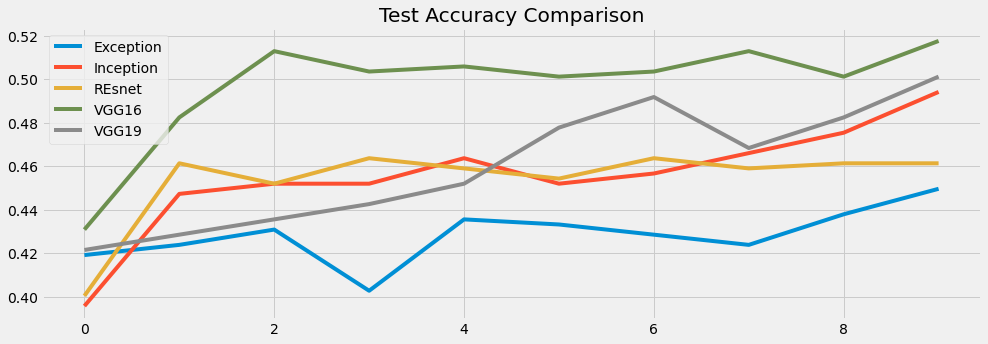

In [80]:
plt.figure(figsize=(15,5))
plt.title("Test Accuracy Comparison")
plt.plot(history_xception.history["val_accuracy"],label = "Exception")
plt.plot(history_inception.history["val_accuracy"],label = "Inception")
plt.plot(history_resnet.history["val_accuracy"],label = "REsnet")
plt.plot(history_vgg1.history["val_accuracy"],label = "VGG16")
plt.plot(history_vgg2.history["val_accuracy"],label = "VGG19")
plt.legend()
plt.show()

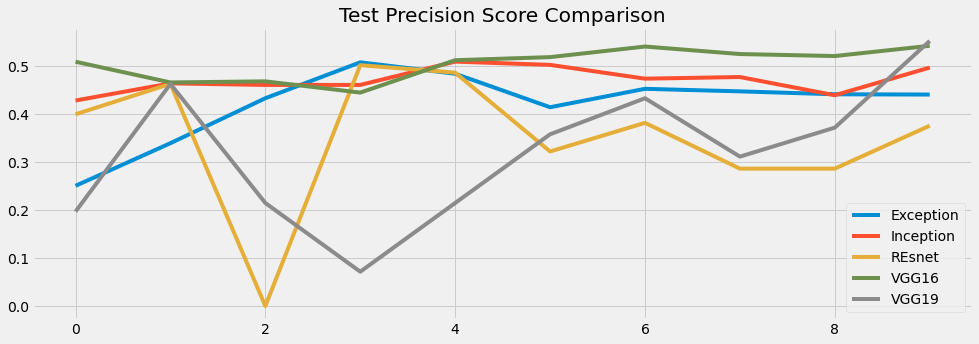

In [81]:
plt.figure(figsize=(15,5))
plt.title("Test Precision Score Comparison")
plt.plot(history_xception.history["val_precision_score"],label = "Exception")
plt.plot(history_inception.history["val_precision_score"],label = "Inception")
plt.plot(history_resnet.history["val_precision_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_precision_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_precision_score"],label = "VGG19")
plt.legend()
plt.show()

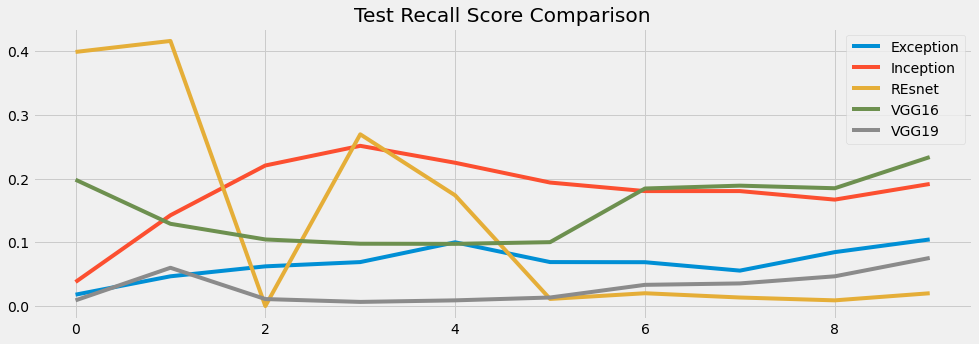

In [82]:
plt.figure(figsize=(15,5))
plt.title("Test Recall Score Comparison")
plt.plot(history_xception.history["val_recall_score"],label = "Exception")
plt.plot(history_inception.history["val_recall_score"],label = "Inception")
plt.plot(history_resnet.history["val_recall_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_recall_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_recall_score"],label = "VGG19")
plt.legend()
plt.show()

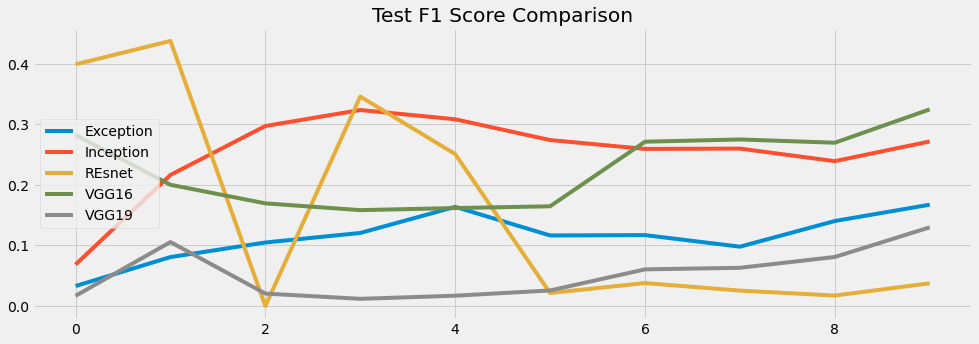

In [83]:
plt.figure(figsize=(15,5))
plt.title("Test F1 Score Comparison")
plt.plot(history_xception.history["val_f1_score"],label = "Exception")
plt.plot(history_inception.history["val_f1_score"],label = "Inception")
plt.plot(history_resnet.history["val_f1_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_f1_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_f1_score"],label = "VGG19")
plt.legend()
plt.show()

# Accent Prediction

In [85]:
label = pd.get_dummies(train['Continent'])
X_train, X_test, y_train, y_test = train_test_split(X, label, random_state=42, test_size=0.2)

In [86]:
model_xception,model_inception,model_vgg1,model_vgg2,model_resnet = define_models(y_train.shape[1])

### Xception

In [87]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_xception.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")

history_xception = model_xception.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/10
54/54 [==============================] - 23s 235ms/step - loss: 2.3890 - accuracy: 0.1675 - recall_score: 0.0721 - precision_score: 0.2030 - f1_score: 0.1056 - val_loss: 1.7708 - val_accuracy: 0.2459 - val_recall_score: 0.0000e+00 - val_precision_score: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/10
54/54 [==============================] - 9s 172ms/step - loss: 2.1789 - accuracy: 0.1870 - recall_score: 0.0691 - precision_score: 0.2313 - f1_score: 0.1057 - val_loss: 1.7022 - val_accuracy: 0.3091 - val_recall_score: 0.0000e+00 - val_precision_score: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/10
54/54 [==============================] - 9s 175ms/step - loss: 1.9669 - accuracy: 0.2106 - recall_score: 0.0560 - precision_score: 0.2530 - f1_score: 0.0904 - val_loss: 1.6725 - val_accuracy: 0.2974 - val_recall_score: 0.0000e+00 - val_precision_score: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/10
54/54 [==============================] - 10s 191ms/step

In [ ]:
pred = np.argmax(model_xception.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)
sensitivity,specificity = spec_sens(conf_matrix)
print('xception Test Sensitivity per class: ' ,sensitivity)
print('xception Test Specificity per class: ' , specificity)

xception Test Sensitivity per class:  [       nan 0.04545455        nan 0.27586207        nan        nan
 0.                nan 0.48355263]
xception Test Specificity per class:  [0.97759104 0.93134328 0.93557423 0.74695122 0.92997199 0.98879552
 0.98591549 0.98039216 0.56603774]


### Inception V3

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_inception.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_inception= model_inception.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/10
363/363 [==============================] - 54s 130ms/step - loss: 2.5047 - accuracy: 0.2198 - recall_score: 0.0735 - precision_score: 0.2213 - f1_score: 0.1072 - val_loss: 2.3896 - val_accuracy: 0.3277 - val_recall_score: 0.2213 - val_precision_score: 0.2213 - val_f1_score: 0.2213
Epoch 2/10
363/363 [==============================] - 47s 130ms/step - loss: 1.8360 - accuracy: 0.3668 - recall_score: 0.1979 - precision_score: 0.4495 - f1_score: 0.2648 - val_loss: 1.8781 - val_accuracy: 0.3950 - val_recall_score: 0.2129 - val_precision_score: 0.2129 - val_f1_score: 0.2129
Epoch 3/10
363/363 [==============================] - 46s 126ms/step - loss: 1.7110 - accuracy: 0.4085 - recall_score: 0.2157 - precision_score: 0.4668 - f1_score: 0.2849 - val_loss: 1.8297 - val_accuracy: 0.3810 - val_recall_score: 0.2353 - val_precision_score: 0.2353 - val_f1_score: 0.2353
Epoch 4/10
363/363 [==============================] - 44s 122ms/step - loss: 1.7026 - accuracy

In [89]:
pred = np.argmax(model_inception.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)
sensitivity,specificity = spec_sens(conf_matrix)
print('Inception Test Sensitivity per class: ' ,sensitivity)
print('Inception Test Specificity per class: ' , specificity)

Inception Test Sensitivity per class:  [0.         0.19148936 0.24695122 0.36              nan        nan]
Inception Test Specificity per class:  [0.9025     0.70526316 0.68686869 0.73134328 0.97423888 0.93676815]


### VGG16

In [90]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_vgg1.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_vgg1= model_vgg1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/10
54/54 [==============================] - 13s 178ms/step - loss: 2.2650 - accuracy: 0.1926 - recall_score: 0.0667 - precision_score: 0.2357 - f1_score: 0.1025 - val_loss: 1.6992 - val_accuracy: 0.2951 - val_recall_score: 0.0000e+00 - val_precision_score: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/10
54/54 [==============================] - 9s 162ms/step - loss: 2.1384 - accuracy: 0.1992 - recall_score: 0.0552 - precision_score: 0.2173 - f1_score: 0.0863 - val_loss: 1.6787 - val_accuracy: 0.2693 - val_recall_score: 0.0000e+00 - val_precision_score: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/10
54/54 [==============================] - 9s 164ms/step - loss: 2.0060 - accuracy: 0.2105 - recall_score: 0.0515 - precision_score: 0.2475 - f1_score: 0.0837 - val_loss: 1.6345 - val_accuracy: 0.2623 - val_recall_score: 0.0000e+00 - val_precision_score: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/10
54/54 [==============================] - 9s 166ms/step 

In [93]:
pred = np.argmax(model_vgg1.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)
sensitivity,specificity = spec_sens(conf_matrix)
print('VGG16 Test Sensitivity per class: ' ,sensitivity)
print('VGG16 Test Specificity per class: ' , specificity)

VGG16 Test Sensitivity per class:  [       nan 0.42028986 0.31775701 0.35416667        nan        nan]
VGG16 Test Specificity per class:  [0.90866511 0.74301676 0.79342723 0.76678445 0.97423888 0.93676815]


### VGG19

In [94]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_vgg2.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_vgg2= model_vgg2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/10
54/54 [==============================] - 15s 212ms/step - loss: 2.4018 - accuracy: 0.1741 - recall_score: 0.0594 - precision_score: 0.1598 - f1_score: 0.0857 - val_loss: 1.7030 - val_accuracy: 0.2904 - val_recall_score: 0.0000e+00 - val_precision_score: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/10
54/54 [==============================] - 11s 196ms/step - loss: 2.1235 - accuracy: 0.2240 - recall_score: 0.0735 - precision_score: 0.2467 - f1_score: 0.1119 - val_loss: 1.6592 - val_accuracy: 0.2904 - val_recall_score: 0.0000e+00 - val_precision_score: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/10
54/54 [==============================] - 11s 201ms/step - loss: 1.9826 - accuracy: 0.2504 - recall_score: 0.0718 - precision_score: 0.2708 - f1_score: 0.1128 - val_loss: 1.6319 - val_accuracy: 0.2904 - val_recall_score: 0.0000e+00 - val_precision_score: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/10
54/54 [==============================] - 11s 199ms/st

In [95]:
pred = np.argmax(model_vgg2.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)
sensitivity,specificity = spec_sens(conf_matrix)
print('VGG19 Test Sensitivity per class: ' ,sensitivity)
print('VGG19 Test Specificity per class: ' , specificity)

VGG19 Test Sensitivity per class:  [       nan 0.30259366 0.34782609 0.58823529        nan        nan]
VGG19 Test Specificity per class:  [0.90866511 0.8        0.7480315  0.75318066 0.97423888 0.93676815]


### ResNet

In [96]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_resnet.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_resnet= model_resnet.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/10
54/54 [==============================] - 23s 221ms/step - loss: 2.3446 - accuracy: 0.1665 - recall_score: 0.0688 - precision_score: 0.2094 - f1_score: 0.1016 - val_loss: 1.9029 - val_accuracy: 0.2623 - val_recall_score: 0.0000e+00 - val_precision_score: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/10
54/54 [==============================] - 7s 130ms/step - loss: 2.1394 - accuracy: 0.1849 - recall_score: 0.0545 - precision_score: 0.2299 - f1_score: 0.0871 - val_loss: 1.6396 - val_accuracy: 0.2810 - val_recall_score: 0.0000e+00 - val_precision_score: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/10
54/54 [==============================] - 7s 130ms/step - loss: 1.9930 - accuracy: 0.2057 - recall_score: 0.0414 - precision_score: 0.1948 - f1_score: 0.0675 - val_loss: 1.6375 - val_accuracy: 0.2857 - val_recall_score: 0.0000e+00 - val_precision_score: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/10
54/54 [==============================] - 7s 131ms/step 

In [97]:
pred = np.argmax(model_resnet.predict(X_test),axis=1)
y_label=  np.argmax((y_test.values),axis=1)
conf_matrix = confusion_matrix(pred,y_label)
sensitivity,specificity = spec_sens(conf_matrix)
print('Resnet Test Sensitivity per class: ' ,sensitivity)
print('Resnet Test Specificity per class: ' , specificity)

Resnet Test Sensitivity per class:  [       nan 0.312      0.31304348 0.26737968        nan        nan]
Resnet Test Specificity per class:  [0.90866511 0.72847682 0.75641026 0.72083333 0.97423888 0.93676815]


### Stacking Ensemble

In [98]:
stack_models = [model_xception,model_inception,model_vgg1,model_vgg2,model_resnet]
model = fit_models(stack_models,X_train,y_train)
stack_prediction_labels = stacked_prediction(stack_models, model, X_test)
y_label=  np.argmax((y_test.values),axis=1)
acc = acc_score(y_label, stack_prediction_labels)
recall = rec_score(y_label, stack_prediction_labels,average="weighted")
precision = prec_score(y_label, stack_prediction_labels,average="weighted")
fscore = f_scores(y_label, stack_prediction_labels,average="weighted")
conf_matrix = confusion_matrix(y_label, stack_prediction_labels)
print('Stacked Test Accuracy: %.3f' % acc)
print('Stacked Test Recall: %.3f' % recall)
print('Stacked Test Precision: %.3f' % precision)
print('Stacked Test F1Score : %.3f' % fscore)
print('Stacked Test F1Score : %.3f' % fscore)
sensitivity,specificity = spec_sens(conf_matrix)
print('Stacked Test Sensitivity per class: ' % sensitivity)
print('Stacked Test Specificity per class: ' % specificity)

Stacked Test Accuracy: 0.342
Stacked Test Recall: 0.342
Stacked Test Precision: 0.295
Stacked Test F1Score : 0.304
Stacked Test F1Score : 0.304
Stacked Test Sensitivity per class: 
Stacked Test Specificity per class: 


### Plotting Graphs

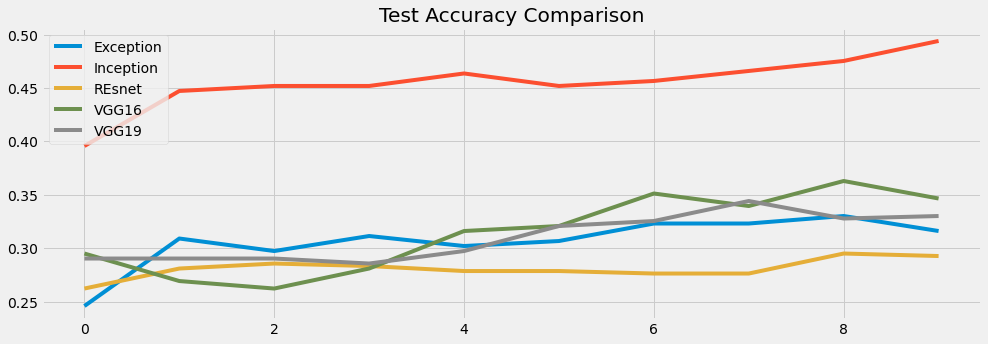

In [99]:
plt.figure(figsize=(15,5))
plt.title("Test Accuracy Comparison")
plt.plot(history_xception.history["val_accuracy"],label = "Exception")
plt.plot(history_inception.history["val_accuracy"],label = "Inception")
plt.plot(history_resnet.history["val_accuracy"],label = "REsnet")
plt.plot(history_vgg1.history["val_accuracy"],label = "VGG16")
plt.plot(history_vgg2.history["val_accuracy"],label = "VGG19")
plt.legend()
plt.show()

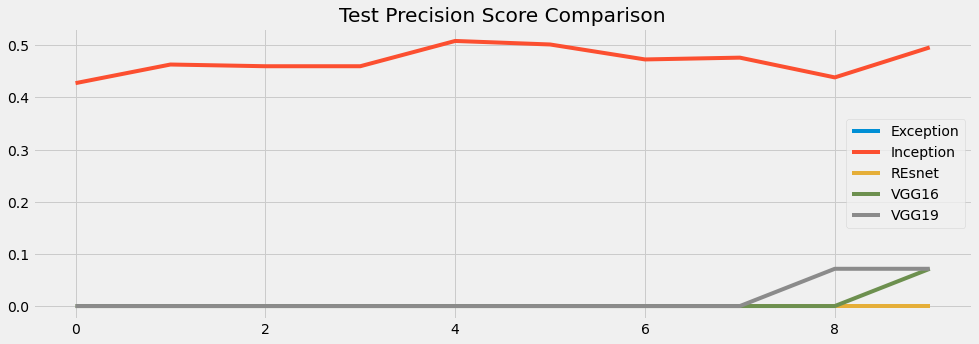

In [100]:
plt.figure(figsize=(15,5))
plt.title("Test Precision Score Comparison")
plt.plot(history_xception.history["val_precision_score"],label = "Exception")
plt.plot(history_inception.history["val_precision_score"],label = "Inception")
plt.plot(history_resnet.history["val_precision_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_precision_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_precision_score"],label = "VGG19")
plt.legend()
plt.show()

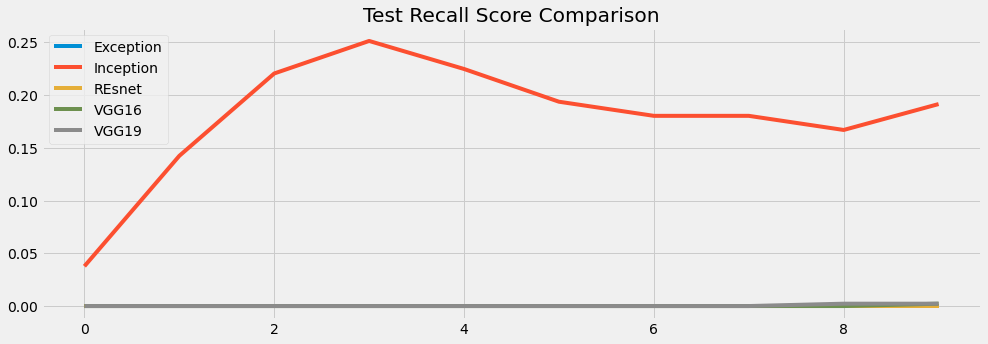

In [101]:
plt.figure(figsize=(15,5))
plt.title("Test Recall Score Comparison")
plt.plot(history_xception.history["val_recall_score"],label = "Exception")
plt.plot(history_inception.history["val_recall_score"],label = "Inception")
plt.plot(history_resnet.history["val_recall_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_recall_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_recall_score"],label = "VGG19")
plt.legend()
plt.show()

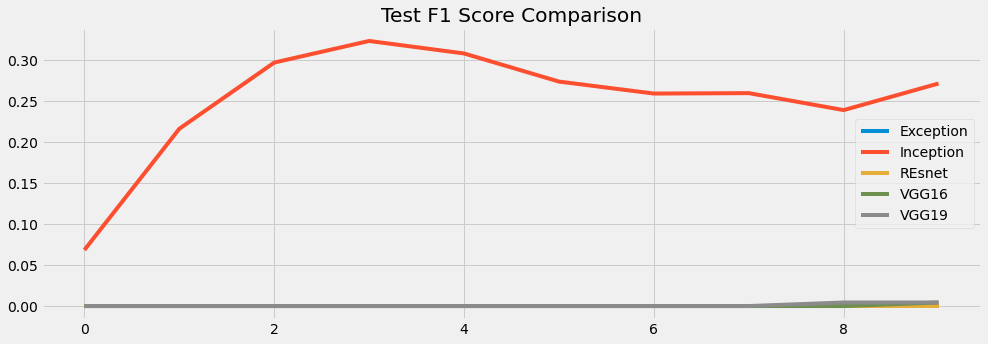

In [103]:
 plt.figure(figsize=(15,5))
plt.title("Test F1 Score Comparison")
plt.plot(history_xception.history["val_f1_score"],label = "Exception")
plt.plot(history_inception.history["val_f1_score"],label = "Inception")
plt.plot(history_resnet.history["val_f1_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_f1_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_f1_score"],label = "VGG19")
plt.legend()
plt.show()